# **Build Model**
https://github.com/theanhtran372000/Vietnamese-News-Classification/blob/main/4.PhoBERT.ipynb



## **Install Library**

In [ ]:
pip install pyvi

In [ ]:
!pip3 install fairseq

In [ ]:
!pip3 install fastbpe

In [ ]:
!pip3 install transformers

In [ ]:
!pip install underthesea

In [ ]:
pip install -U flask-cors

In [ ]:
!pip install pytorch-model-summary

## **Import Library**

In [1]:
import sys
import os
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import time
import random
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm
import argparse

from flask import Flask, request,render_template,jsonify
from flask_cors import CORS
import flask

from pyvi import ViTokenizer
from wordcloud import WordCloud, STOPWORDS

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.backends import cudnn
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, classification_report, accuracy_score
from sklearn.utils import class_weight, resample, shuffle
from sklearn.manifold import TSNE

from collections import Counter
from imblearn.over_sampling import SMOTE
from underthesea import word_tokenize
import pickle

from fairseq.models.roberta import RobertaModel
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from transformers.modeling_utils import *
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from transformers import AutoModel, AutoTokenizer

import argparse

app = Flask(__name__)
CORS(app)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Load Data***

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/prob_1_df.csv', usecols=lambda x: x != 'Unnamed: 0')

In [3]:
# test_df = pd.read_csv('/content/drive/MyDrive/Research - CSR_NLP/test_df.csv')

train_df = df.copy()
train_df.to_csv('/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/prob_1_train_df.csv', index = False)
# test_df.to_csv('/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/prob_1_test_df.csv', index = False)

In [ ]:
# np.mean(question['num_word'])

34.38500694123091

(array([535., 513., 502., 305., 149.,  75.,  47.,  23.,   7.,   5.]),
 array([  1. ,  15.7,  30.4,  45.1,  59.8,  74.5,  89.2, 103.9, 118.6,
        133.3, 148. ]),
 <BarContainer object of 10 artists>)

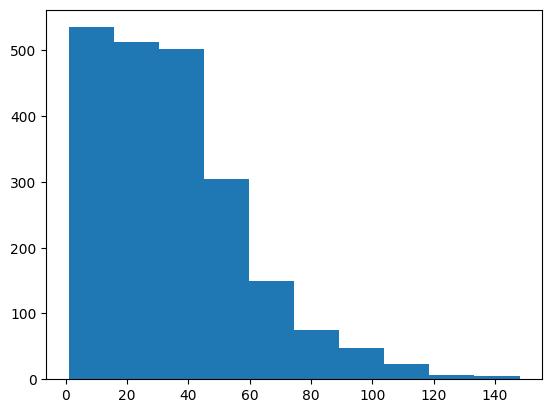

In [ ]:
# plt.hist(list(question['num_word']), bins = 10)

## **Preprocessing Text./**

In [4]:
test_dir = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/prob_1_test_df.csv'
train_dir = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/prob_1_train_df.csv'

In [5]:
test_df = pd.read_csv(test_dir, usecols=lambda x: x != 'Unnamed: 0')
train_df = pd.read_csv(train_dir, usecols=lambda x: x != 'Unnamed: 0')

**Preprocessing:**

1) Xóa HTML code

2) Chuẩn hóa bảng mã Unicode

3) Chuẩn hóa kiểu gõ dấu tiếng việt

4) Tách từ tiếng Việt

5) Đưa về dạng viết thường

6) Xóa ký tự đặc biệt

#### ***Đặt hàm xử lý text***

In [8]:
'''
Xóa HTML code
'''
def remove_html(text):
    return re.sub(r'<[^>]*>', '', text)

In [9]:
'''
Chuẩn hóa bảng mã Unicode
  * Đưa hết những câu trong dataset về thành kiểu Unicode dựng sẵn.
'''
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

# Hàm tạo dict để convert định dạng cũ sang định dạng mới
def loaddicchar():
  dic = {}
  char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')
  charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')
  for i in range(len(char1252)):
      dic[char1252[i]] = charutf8[i]
  return dic

dicchar = loaddicchar()

# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [10]:
'''
Chuẩn hóa kiểu gõ dấu tiếng Việt & đưa về dạng thường
  - Lỗi gõ dấu thường xảy ra do cách đánh máy của người viết báo
  - Chuyển các từ về dạng viết thường sẽ giảm số lượng đặc trưng mà mô hình phải học => tăng độ chính xác model
'''
# Danh sách nguyên âm với các dấu tương ứng
bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

# Bảng chứa ký tự dấu ứng: dấu trắng, dấu huyền, sắc, hỏi, ngã, nặng ứng với các cột bên trên
bang_ky_tu_dau =  [ '', 'f', 's', 'r', 'x', 'j']

# dict để chuyển ký tự unicode sang chỉ số (i, j) trong đó i đặc trưng cho nguyên âm nào còn j đặc trưng cho dấu
nguyen_am_to_ids = {}

# Khởi tạo dict
for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

# Kiểm tra tính hợp lệ của một từ tiếng Việt đã được gõ đúng hay chưa dựa trên tính chất là:
# Các nguyên âm trong tiếng việt sẽ đứng cạnh nhau tạo thành cụm và mỗi từ chỉ có tối đa 1 cụm nguyên âm
# Ví dụ: Nguyễn -> Ng(uyễ)n, Thắng -> Th(ắ)ng, Hảo -> H(ảo)
def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1

    # duyệt từng ký tự trong word
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1)) # x xác định nguyên âm nào còn y sẽ xác định dấu ứng với nguyên âm đó
        if x != -1: # nếu char là nguyên âm
            if nguyen_am_index == -1: # nếu chưa tìm thấy nguyên âm
                nguyen_am_index = index
            else:                     # đã tìm thấy nguyên âm
                if index - nguyen_am_index != 1: # nếu nguyên âm tìm thấy ko nằm cạnh nguyên âm đã tìm thấy
                    return False
                nguyen_am_index = index
    return True

print("Nguyene: ", is_valid_vietnam_word("Nguyene"))
print('Nguyễn: ', is_valid_vietnam_word('Nguyễn'))

Nguyene:  False
Nguyễn:  True


In [11]:
# Thực hiện chuẩn hóa dấu cho từng từ trong tiếng Việt
def chuan_hoa_dau_tu_tieng_viet(word):
    # Nếu là invalid word thì sẽ không xử lý bao gồm từ tiếng anh, số, từ gõ sai, ...
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False

    # Duyệt qua từng ký tự
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1: # Nếu char là phụ âm
            continue

        elif x == 9:  # check 'qu'
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True

        elif x == 5:  # check 'gi'
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:  # nếu có dấu
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0] # bỏ dấu

        # Nếu không phải trường hợp 'qu' hoặc 'gi' hoặc là index khác 1 (có nguyên âm từ ký tự thứ 3 trở đi)
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)

    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

# Thực hiện chuẩn hóa cho cả câu tiếng Việt và đưa câu đó về dạng viết thường
def chuan_hoa_dau_cau_tieng_viet(sentence):
    sentence = sentence.lower() # Chuyển về dạng lowercase
    words = sentence.split()

    # thực hiện xử lý trên từng từ
    for index, word in enumerate(words):
        cw = re.sub(r'^([b-dđghklmnpqrstv-xzB-DĐGHKLMNPQRSTV-XZ]*)([aăâeêioôơuưy]*[aăâeêioôơuưy]{1}[aăâeêioôơuưy]*)([b-dđghklmnpqrstv-xzB-DĐGHKLMNPQRSTV-XZ]*)$', r'\1/\2/\3', word).split('/')
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

print(chuan_hoa_dau_cau_tieng_viet('đường mật có hại không? không Ai BiẾt. Chúng TôI cHỉ BiếT là KiẾn thích đườNg'))

đường mật có hại không? không ai biết. chúng tôi chỉ biết là kiến thích đường


In [12]:
'''
Tách từ tiếng việt:
  - Đơn vị từ có từ đơn & từ ghép => tăng chính xác đáng kể khi không cần học sự liên kết giữa 2 từ trong 1 từ ghép
  - Nối 2 từ lại
  => sử dụng undersea
'''
sentence = 'Có một con bò ở trên cành cây.'
print(word_tokenize(sentence))
print(word_tokenize(sentence, format='text'))

['Có', 'một', 'con', 'bò', 'ở', 'trên', 'cành', 'cây', '.']
Có một con bò ở trên cành cây .


In [13]:
'''
Xóa các ký tự không cần thiết:
  - Giảm chiều đặc trưng, tăng tốc độ học, xử lý
  - Tránh gây nhiễu cho mô hình
Loại bỏ những ký tự không cần thiết như dấu ngắt câu '\n' và các ký tự đặc biệt.
'''
def remove_unnecessary_charactor(document):
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

**Hàm tổng hợp preprocessing text**

In [14]:
def text_preprocessing(document):
  # xóa html
  document = remove_html(document)
  # chuẩn hóa unicode
  document = convert_unicode(document)
  # chuẩn hóa các gõ dấu và đưa về dạng viết thường
  document = chuan_hoa_dau_cau_tieng_viet(document)
  # tách từ
  document = word_tokenize(document, format='text')
  # xóa bỏ ký tự không cần thiết
  document = remove_unnecessary_charactor(document)
  return document

In [15]:
text_preprocessing(df.text[0])

'sau khi hđqt chính_thức ban_hành sơ_đồ cơ_cấu tổ_chức mới của vpbank khối khcn sme đã hoạt_động từ tháng 72011'

#### ***Xử lý text***

In [16]:
test_df['text'] = test_df['text'].apply(text_preprocessing)
train_df['text'] = train_df['text'].apply(text_preprocessing)

#### ***Loại Stopwords:*** *chưa chắc đã cần*

In [17]:
# Tạo bảng tần số của các từ
count = {}
print('Processing news ...')
for content in train_df['text'].astype(str).tolist() + test_df['text'].astype(str).tolist():
    words = content.split(' ')
    for word in words:
        if word not in count:
            count[word] = 1
        else:
            count[word] += 1

print('Number of words in dataset: ', len(count))

Processing news ...
Number of words in dataset:  10705


In [18]:
sorted_count = sorted(count, key=count.get, reverse=True)
# top 100 từ xuất hiện nhiều nhất
for word in np.array(sorted_count)[:10]:
    print(f'{word} - {count[word]}')

và - 7761
các - 7124
của - 5112
trong - 3577
cho - 3195
được - 2935
với - 2890
năm - 2830
ngân_hàng - 2528
đã - 2119


In [19]:
'''
Import Vietnamese stopwords: '/content/drive/MyDrive/Research - CSR_NLP/Code/vietnamese-stopwords-dash.txt'
'''
def import_file(filename):
    with open(filename, 'r') as file:
        content = file.readlines()
    # Remove trailing newline characters
    content = [line.rstrip('\n') for line in content]
    return content

# Provide the filename of the text file you want to import
file_name = '/content/drive/MyDrive/Research - CSR_NLP/Code/vietnamese-stopwords-dash.txt'
file_contents = import_file(file_name)

# Now you can use the file_contents list containing the lines of the text file
print(file_contents)


['và', 'các', 'của', 'trong', 'cho', 'được', 'với', 'đã', 'cid', 'những', 'đó', 'sự', 'cũng', 'này', 'sẽ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', 'mà', 'hoặc']


In [20]:
stopwords = set()
for word in file_contents:
  stopwords.add(word)

stopwords.add('đến')

In [21]:
import re

def remove_stopwords(document):
    words = document.split(' ')
    res = []
    for word in words:
        # Remove numbers from the word using regex
        word_without_numbers = re.sub(r'\d', '', word)
        if word_without_numbers not in stopwords:
            res.append(word_without_numbers)
    return ' '.join(res)

In [22]:
# Kiểm tra
remove_stopwords(text_preprocessing('Theo nghị định đã ban hành, người dân cần ở trong nhà đến hết ngày 16/9.'))

'theo nghị_định ban_hành người dân cần ở nhà hết ngày '

In [23]:
# Thực hiện trên toàn bộ dữ liệu
print('Processing training set ... ')
for i, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    train_df.at[i, 'text'] = remove_stopwords(row['text'])

Processing training set ... 


  0%|          | 0/9027 [00:00<?, ?it/s]

In [24]:
print('Processing testing set ... ')
for i, row in tqdm(test_df.iterrows(), total=test_df.shape[0]):
    test_df.at[i, 'text'] = remove_stopwords(row['text'])

Processing testing set ... 


  0%|          | 0/2257 [00:00<?, ?it/s]

In [25]:
# Remove rows with empty or whitespace-only values in 'text' column
train_df = train_df[train_df['text'].str.strip().astype(bool)]
test_df = test_df[test_df['text'].str.strip().astype(bool)]

In [26]:
train_df = train_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

## **Build Model: PhoBERT**


In [31]:
train_x = train_df['text']
train_y = train_df['label']

test_x = test_df['text']
test_y = test_df['label']

Các bước xử lý


1.   Tiền xử lý sentence (nếu cần)
2.   Tokenize bằng tokenizer của PhoBERT (Thêm 2 token đặc biệt là CLS và SEP vào đầu và cuối câu)
1.   Đưa câu văn đã được tokenize vào model kèm theo attention mask
1.   Lấy vector output đầu tiên (tại vị trí CLS) để làm đầu vào của classifier


In [32]:
# load model phoBert và tokenizer của model đó
phoBert = AutoModel.from_pretrained('vinai/phobert-base')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Tokenize văn vản và đưa về kích thước cố định

In [33]:
# Đưa từng sentence qua tokenizer của PhoBERT để convert sang dạng token index với cùng chiều dài
# params
MAX_SEQ_LEN = 256 # chiều dài tối đa của một câu
# id của 1 số token đặc biệt
cls_id = 0  # đầu câu
eos_id = 2  # cuối câu
pad_id = 1  # padding

# Hàm xử lý dữ liệu trên từng sentence
def tokenize_line(line):
    tokenized = tokenizer.encode(line)

    l = len(tokenized)
    if l > MAX_SEQ_LEN: # nếu dài hơn thì cắt bỏ
        tokenized = tokenized[:MAX_SEQ_LEN]
        tokenized[-1] = eos_id # thêm EOS vào cuối câu
    else: # nếu ngắn hơn thì thêm padding vào
        tokenized = tokenized + [pad_id, ] * (MAX_SEQ_LEN - l)

    return tokenized

In [34]:
tokenized = tokenize_line('tôi khỏe')
print('After encode: ', tokenized)
print('Token size: ', len(tokenized))

After encode:  [0, 70, 3014, 15947, 1565, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Token size:  256


In [35]:
# Xử lý trên toàn tập dữ liệu
tokenized_train_x = []
tokenized_test_x = []

start = time.time()

print('Tokenizing train set ...')
for x in tqdm(train_x):
    tokenized_train_x.append(tokenize_line(x))

print('Tokenizing test set ... ')
for x in tqdm(test_x):
    tokenized_test_x.append(tokenize_line(x))

print('Done after %d seconds' %(time.time() - start))

Tokenizing train set ...


  0%|          | 0/8727 [00:00<?, ?it/s]

Tokenizing test set ... 


  0%|          | 0/2211 [00:00<?, ?it/s]

Done after 2 seconds


In [36]:
# Tạo attention mask để model chỉ tập trung vào phần nội dung mà không quan tâm tới phần padding
train_attention_mask = []
for x in tokenized_train_x:
    train_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

test_attention_mask = []
for x in tokenized_test_x:
    test_attention_mask.append(np.where(np.array(x) == 1, 0, 1))

print('Done!')

Done!


### Đưa dữ liệu kèm theo attention mask vào model PhoBERT

In [37]:
# convert sang tensor
tokenized = torch.tensor(tokenized_train_x[:1]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:1])

with torch.no_grad():
    last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

print(last_hidden_states[0].shape)

<ipython-input-37-4bdc17b2193f>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  attention_mask = torch.tensor(train_attention_mask[:1])


torch.Size([1, 256, 768])


Nhận xét: Dữ liệu trả về là 1 tensor có size là (1, 256, 768) trong đó 1 là số sentence truyền vào, 256 là độ dài của mỗi sentence và 768 là vector embedding cho mỗi word của sentence đó. Bởi vì ta sẽ sử dụng vector embedding của token CLS để classify nên ta sẽ lấy vector embedding của từ đầu tiên của mọi câu.

In [38]:
# Vector embedding của train set
tokenized = torch.tensor(tokenized_train_x[:500]).to(torch.long)
attention_mask = torch.tensor(train_attention_mask[:500])

start = time.time()

with torch.no_grad():
    last_hidden_states = phoBert(input_ids=tokenized, attention_mask=attention_mask)

train_features = last_hidden_states[0][:, 0, :].numpy()
print('Finish extracting features after %d seconds' %(time.time() - start))

print('Output shape: ', train_features.shape)

Finish extracting features after 474 seconds
Output shape:  (500, 768)


In [39]:
# Hàm extract feature của 1 line
def extract_line(tokenized, mask):
    tokenized = torch.tensor(tokenized).to(torch.long)
    mask = torch.tensor(mask)

    with torch.no_grad():
        last_hidden_states = phoBert(input_ids=tokenized, attention_mask=mask)

    feature = last_hidden_states[0][:, 0, :].numpy()

    return feature

In [40]:
# Embed tập train
train_size = len(tokenized_train_x)
EMBED_SIZE = 768
train_features = np.zeros(shape=(train_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, train_size, step)):
    mask = train_attention_mask[i:i+step]
    tokenized = tokenized_train_x[i:i+step]
    feature = extract_line(tokenized, mask)
    train_features[i:i+step] = feature

# save embed list
bert_features_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/bert_features.sav'
pickle.dump(train_features, open(bert_features_path, 'wb'))

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', train_features.shape)

  0%|          | 0/437 [00:00<?, ?it/s]

Finish extracting features after 8003 seconds
Output shape:  (8727, 768)


In [41]:
# Thực hiện tương tự trên tập test
test_size = len(tokenized_test_x)
EMBED_SIZE = 768
test_features = np.zeros(shape=(test_size, EMBED_SIZE))

start = time.time()

step = 20
for i in tqdm(range(0, test_size, step)):
    mask = test_attention_mask[i:i+step]
    tokenized = tokenized_test_x[i:i+step]
    feature = extract_line(tokenized, mask)
    test_features[i:i+step] = feature

bert_test_features_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/bert_test_features.sav'
pickle.dump(test_features, open(bert_test_features_path, 'wb'))

print('Finish extracting features after %d seconds' %(time.time() - start))
print('Output shape: ', test_features.shape)

  0%|          | 0/111 [00:00<?, ?it/s]

Finish extracting features after 2050 seconds
Output shape:  (2211, 768)


In [42]:
bert_test_features_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/bert_test_features.sav'
bert_features_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/bert_features.sav'

# load vector embedding đã lưu
train_features = pickle.load(open(bert_features_path, 'rb'))
test_features = pickle.load(open(bert_test_features_path, 'rb'))

In [43]:
# save lại các tokenize
tokenized_train_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/tokenized_train_x.sav'
tokenized_test_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/tokenized_test_x.sav'
amask_train_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/train_attention_mask.sav'
amask_test_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Variable/test_attention_mask.sav'

In [44]:
pickle.dump(tokenized_train_x, open(tokenized_train_path, 'wb'))
pickle.dump(tokenized_test_x, open(tokenized_test_path, 'wb'))
pickle.dump(train_attention_mask, open(amask_train_path, 'wb'))
pickle.dump(test_attention_mask, open(amask_test_path, 'wb'))

In [ ]:
tokenized_train_x = pickle.load(open(tokenized_train_path, 'rb'))
tokenized_test_x = pickle.load(open(tokenized_test_path, 'rb'))
train_attention_mask = pickle.load(open(amask_train_path, 'rb'))
test_attention_mask = pickle.load(open(amask_test_path, 'rb'))

**Đánh giá khả năng phân cụm của PhoBERT**

In [46]:
# visualize embedded vector dưới góc nhìn 2 chiều
tsne = TSNE(n_components=2, random_state=0)
x_2d = tsne.fit_transform(test_features)
print('Embedded shape: ', x_2d.shape)

ValueError: ignored

In [45]:
labels = df.label.unique()
print('Number of labels: ', len(labels))
labels = sorted(labels)

Number of labels:  2


In [ ]:
# visualize
plt.figure(figsize=(20, 12))
color_map = {
    0: 'red', 1: 'blue'
}

train_y = np.array(train_y)

for idx, label in enumerate(labels):
    plt.scatter(x=x_2d[train_y == label, 0], y=x_2d[train_y == label, 1], c=color_map[idx], marker='o', label=label)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('2D Visualization of Training Data')
plt.show()

## **Train ML Classifier**

#### ***Logistic Regression Classifier***

In [ ]:
logisticReg = LogisticRegression(max_iter=100_000)

start = time.time()
logisticReg.fit(train_features, train_y)

print('Logistic Regression finish training after %d second' %(time.time() - start))

bert_logreg_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Common Classifier Models/bert_logreg.sav'
pickle.dump(logisticReg, open(bert_logreg_path, 'wb'))

Logistic Regression finish training after 5 second


In [ ]:
# Đánh giá độ chính xác của mô hình Logistic Regression
y_pred = logisticReg.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))

print('Accuracy: ', acc)

Accuracy:  0.8505272810637322


In [ ]:
print(classification_report(test_y, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1704
           1       0.70      0.56      0.62       477

    accuracy                           0.85      2181
   macro avg       0.79      0.75      0.76      2181
weighted avg       0.84      0.85      0.84      2181



<Axes: >

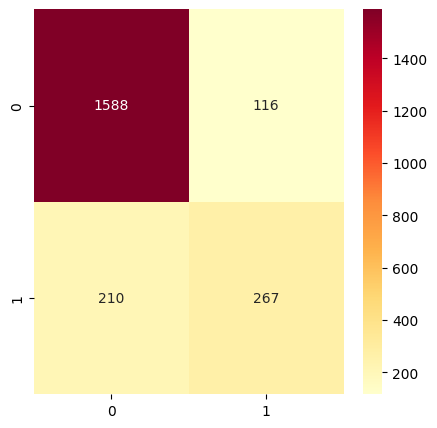

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(5, 5))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

#### ***SVM Classifier***

In [ ]:
svm = SVC()

start = time.time()
svm.fit(train_features, train_y)
print('SVM classifier finish training after %d seconds' %(time.time() - start))

bert_svm_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Common Classifier Models/bert_svm.sav'
pickle.dump(svm, open(bert_svm_path, 'wb'))

SVM classifier finish training after 20 seconds


In [ ]:
# Đánh giá độ chính xác
y_pred = svm.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))
print('Accuracy: ', acc)

Accuracy:  0.8656579550664832


In [ ]:
print(classification_report(test_y, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1704
           1       0.83      0.48      0.61       477

    accuracy                           0.87      2181
   macro avg       0.85      0.73      0.77      2181
weighted avg       0.86      0.87      0.85      2181



<Axes: >

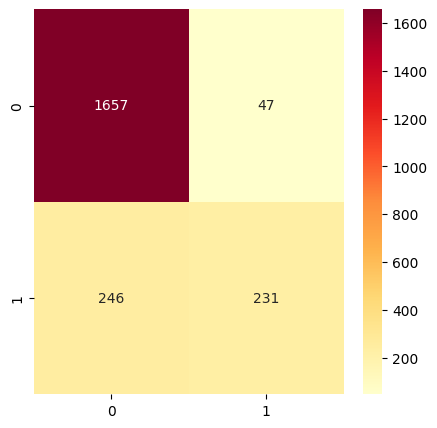

In [ ]:
# visualize bằng heat map
plt.figure(figsize=(5, 5))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd' , xticklabels=labels, yticklabels=labels)

#### ***Random Forest Classifier***

Random Forest classifier finish training after 33 seconds
Accuracy:  0.8399816597890876
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1704
           1       0.90      0.30      0.45       477

    accuracy                           0.84      2181
   macro avg       0.87      0.65      0.68      2181
weighted avg       0.85      0.84      0.81      2181



<Axes: >

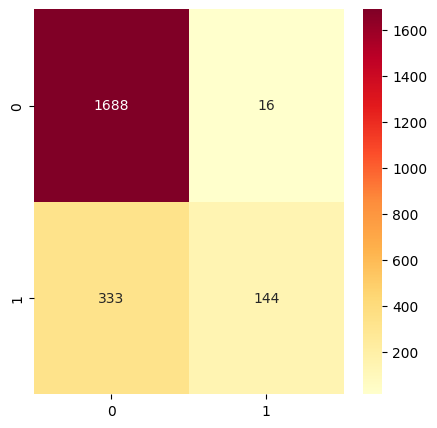

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

start = time.time()
rf.fit(train_features, train_y)
print('Random Forest classifier finish training after %d seconds' %(time.time() - start))

rf_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Common Classifier Models/rf_model.sav'
pickle.dump(rf, open(rf_path, 'wb'))

# Evaluate accuracy
y_pred = rf.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))
print('Accuracy: ', acc)

print(classification_report(test_y, y_pred, zero_division=1))

# Visualize using a heatmap
plt.figure(figsize=(5, 5))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd', xticklabels=labels, yticklabels=labels)


#### ***Neural Networks Classifier***

Neural Networks classifier finish training after 28 seconds
Accuracy:  0.8541953232462174
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1704
           1       0.66      0.69      0.68       477

    accuracy                           0.85      2181
   macro avg       0.79      0.80      0.79      2181
weighted avg       0.86      0.85      0.86      2181



<Axes: >

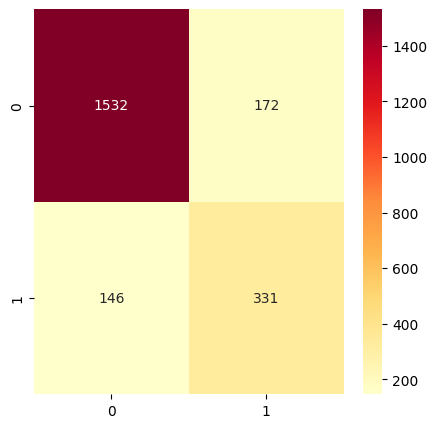

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier()

start = time.time()
nn.fit(train_features, train_y)
print('Neural Networks classifier finish training after %d seconds' %(time.time() - start))

nn_path = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Common Classifier Models/nn_model.sav'
pickle.dump(nn, open(nn_path, 'wb'))

# Evaluate accuracy
y_pred = nn.predict(test_features)

acc = np.mean(y_pred == np.array(test_y))
print('Accuracy: ', acc)

print(classification_report(test_y, y_pred, zero_division=1))

# Visualize using a heatmap
plt.figure(figsize=(5, 5))
conf_matrix = confusion_matrix(test_y, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='YlOrRd', xticklabels=labels, yticklabels=labels)


# **Fine-tune mô hình PhoBERT cho tác vụ classify**

In [ ]:
# Load BPE encoder
parser = argparse.ArgumentParser()
parser.add_argument(
    '--bpe-codes',
    default='/content/drive/MyDrive/Research - CSR_NLP/Code/PhoBERT_base_transformers/PhoBERT_base_transformers/bpe.codes',
    required=False,
    type=str,
    help='path to fastBPE BPE'
)

args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file('/content/drive/MyDrive/Research - CSR_NLP/Code/PhoBERT_base_transformers/PhoBERT_base_transformers/dict.txt')

In [ ]:
# Ví dụ, sử dụng BPE encoder để ánh xạ 1 câu thành một list subwords
bpe.encode('Nhiệt_độ ngoài trời là 37 độ C')

In [ ]:
# ánh xạ từng subwords sang index của nó trong vocab
vocab.encode_line(' ' + 'Nhiệt_độ ngoài trời là 37 độ C' + ' ')

### **Preprocess Data**

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# # encode label
# le = LabelEncoder()
# encoded_train_y = le.fit_transform(train_y)
# print(le.classes_)

In [ ]:
# chia tập train thành 2 phần train và validate với tỉ lệ 9:1
from sklearn.model_selection import train_test_split

train_sents, val_sents, train_labels, val_labels = train_test_split(train_x, train_y, test_size=0.1, random_state = 42)

In [ ]:
# Thực hiện chuyển dataset ban đầu thành subword index
MAX_LEN = 256

train_ids = []
print('Processing train set ...')
for sent in tqdm(train_sents):
  subwords = ' ' + bpe.encode(sent) + ' '
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long()
  train_ids.append(encoded_sent)

val_ids = []
print('Processing test set ...')
for sent in tqdm(val_sents):
  subwords = ' ' + bpe.encode(sent) + ' '
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long()
  val_ids.append(encoded_sent)

Processing train set ...


  0%|          | 0/7881 [00:00<?, ?it/s]

Processing test set ...


  0%|          | 0/876 [00:00<?, ?it/s]

In [ ]:
# thêm padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype='long', value=1, truncating='post', padding='post')
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype='long', value=1, truncating='post', padding='post')

In [ ]:
# sau padding
train_ids[1]

array([ 270, 1575, 1365,  193,   63,  278, 1450, 4739,  926,    2,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,   

In [ ]:
# Tạo mask để BERT không chú ý tới padding (pad id = 1)
train_masks = []
for sent in train_ids:
  mask = [int(token_id != 1) for token_id in sent]
  train_masks.append(mask)

val_masks = []
for sent in val_ids:
  mask = [int(token_id != 1) for token_id in sent]
  val_masks.append(mask)

In [ ]:
val_ids.shape

(876, 256)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 4

# convert sang tensor
train_inputs = torch.tensor(train_ids)
val_inputs = torch.tensor(val_ids)

In [ ]:
train_labels = torch.tensor(train_labels.values)

In [ ]:
val_labels = torch.tensor(val_labels.values)

In [ ]:
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

# tạo data loader để train
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

NUM_CLASSES = len(labels)

# load file config
config = RobertaConfig.from_pretrained(
    '/content/drive/MyDrive/Research - CSR_NLP/Code/PhoBERT_base_transformers/PhoBERT_base_transformers/config.json',
    from_tf=False,
    num_labels=NUM_CLASSES,
    output_hidden_states=False
)

# load model
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    '/content/drive/MyDrive/Research - CSR_NLP/Code/PhoBERT_base_transformers/PhoBERT_base_transformers/model.bin',
    config=config
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/drive/MyDrive/Research - CSR_NLP/Code/PhoBERT_base_transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

In [ ]:
BERT_SA.cuda()
print('Done')

Done


In [ ]:
# Hàm đánh giá độ chính xác
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    F1_score = f1_score(pred_flat, labels_flat, average='macro')

    return accuracy_score(pred_flat, labels_flat), F1_score

## **Training PhoBERT**

In [ ]:
import io
import copy

class EarlyStopping():
    def __init__(self, patience = 10, min_delta=0, restore_best_weights=True):
        '''
        patience = number of epochs not improve
        min_delta = the amount that counted as improvement (0 = any change is an improvement)
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [ ]:
# định nghĩa tham số
device = 'cuda'
epochs = 20
save_dir = '/content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Bert Fine-tune'
best_acc = 0
early_stopping = EarlyStopping()
# lưu lại lịch sử
losses = []
train_accs = []
val_accs = []
val_losses = []

# define optimizer
param_optimizer = list(BERT_SA.named_parameters())

no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

# Train theo từng epoch
for epoch_i in range(0, epochs):
  print('================= Epoch {} / {} ====================='.format(epoch_i + 1, epochs))
  print('Training ... ')

  # Tham số train
  total_loss = 0
  BERT_SA.train()
  train_accuracy = 0
  nb_train_steps = 0
  train_f1 = 0

  # Train từng batch
  for step, batch in enumerate(tqdm(train_dataloader)):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    BERT_SA.zero_grad()
    outputs = BERT_SA(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask,
        labels=b_labels
    )
    loss = outputs[0]
    total_loss += loss.item()

    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
    train_accuracy += tmp_train_accuracy
    train_f1 += tmp_train_f1
    nb_train_steps += 1

    loss.backward()
    torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
    optimizer.step()

  # tính average loss và accuracy cho epoch đó
  avg_train_loss = total_loss / len(train_dataloader)
  losses.append(avg_train_loss)
  train_accs.append(train_accuracy/nb_train_steps)

  print('Accuracy: {0:.4f}'.format(train_accuracy/nb_train_steps))
  print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
  print(" Average training loss: {0:.4f}".format(avg_train_loss))

  print("Running Validation...")

  BERT_SA.eval()

  # tham số validate
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_f1 = 0

  # đánh giá
  for batch in tqdm(val_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = BERT_SA(
          b_input_ids,
          token_type_ids=None,
          attention_mask=b_input_mask
      )
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

      eval_accuracy += tmp_eval_accuracy
      eval_f1 += tmp_eval_f1
      nb_eval_steps += 1

  avg_val_acc = eval_accuracy/nb_eval_steps
  val_accs.append(avg_val_acc)
  print(" Accuracy: {0:.4f}".format(avg_val_acc))
  print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))

  # save checkpoint
  if avg_val_acc > best_acc:
    # save checkpoint
    print('Saved model to %s' %save_dir)
    BERT_SA.save_pretrained(save_dir)
    best_acc = avg_val_acc

#   if early_stopping is not None:
#     if early_stopping(BERT_SA, avg_val_acc):
#       print(f"Early stopping at epoch {epoch_i + 1}.")
#       break

print("Training complete!")

================= Epoch 1 / 20 =====================
Training ... 


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.8499
 F1 score: 0.7532
 Average training loss: 0.4662
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8459
 F1 score: 0.7509
Saved model to /content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Bert Fine-tune
================= Epoch 2 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.8926
 F1 score: 0.8274
 Average training loss: 0.3925
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8733
 F1 score: 0.7782
Saved model to /content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Bert Fine-tune
================= Epoch 3 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9082
 F1 score: 0.8545
 Average training loss: 0.3553
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8664
 F1 score: 0.7761
================= Epoch 4 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9254
 F1 score: 0.8820
 Average training loss: 0.3063
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8779
 F1 score: 0.7972
Saved model to /content/drive/MyDrive/Research - CSR_NLP/Code/Problem 1: Binary/Bert Fine-tune
================= Epoch 5 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9314
 F1 score: 0.8910
 Average training loss: 0.2821
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8436
 F1 score: 0.7487
================= Epoch 6 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9527
 F1 score: 0.9281
 Average training loss: 0.2119
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8242
 F1 score: 0.7339
================= Epoch 7 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9574
 F1 score: 0.9340
 Average training loss: 0.1913
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8162
 F1 score: 0.7272
================= Epoch 8 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9632
 F1 score: 0.9426
 Average training loss: 0.1710
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8379
 F1 score: 0.7454
================= Epoch 9 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9691
 F1 score: 0.9512
 Average training loss: 0.1480
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8756
 F1 score: 0.7973
================= Epoch 10 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9721
 F1 score: 0.9552
 Average training loss: 0.1322
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8642
 F1 score: 0.7827
================= Epoch 11 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9755
 F1 score: 0.9600
 Average training loss: 0.1184
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8493
 F1 score: 0.7547
================= Epoch 12 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9768
 F1 score: 0.9621
 Average training loss: 0.1141
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8607
 F1 score: 0.7776
================= Epoch 13 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9793
 F1 score: 0.9675
 Average training loss: 0.1019
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8699
 F1 score: 0.7868
================= Epoch 14 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9819
 F1 score: 0.9714
 Average training loss: 0.0899
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8756
 F1 score: 0.7908
================= Epoch 15 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9817
 F1 score: 0.9708
 Average training loss: 0.0887
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8779
 F1 score: 0.7999
================= Epoch 16 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9831
 F1 score: 0.9728
 Average training loss: 0.0836
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8756
 F1 score: 0.7940
================= Epoch 17 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9848
 F1 score: 0.9756
 Average training loss: 0.0798
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8744
 F1 score: 0.8007
================= Epoch 18 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9859
 F1 score: 0.9783
 Average training loss: 0.0697
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8619
 F1 score: 0.7847
================= Epoch 19 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9852
 F1 score: 0.9767
 Average training loss: 0.0718
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8710
 F1 score: 0.7960
================= Epoch 20 / 20 =====================
Training ... 


  0%|          | 0/1971 [00:00<?, ?it/s]

Accuracy: 0.9853
 F1 score: 0.9760
 Average training loss: 0.0717
Running Validation...


  0%|          | 0/219 [00:00<?, ?it/s]

 Accuracy: 0.8699
 F1 score: 0.7854
Training complete!


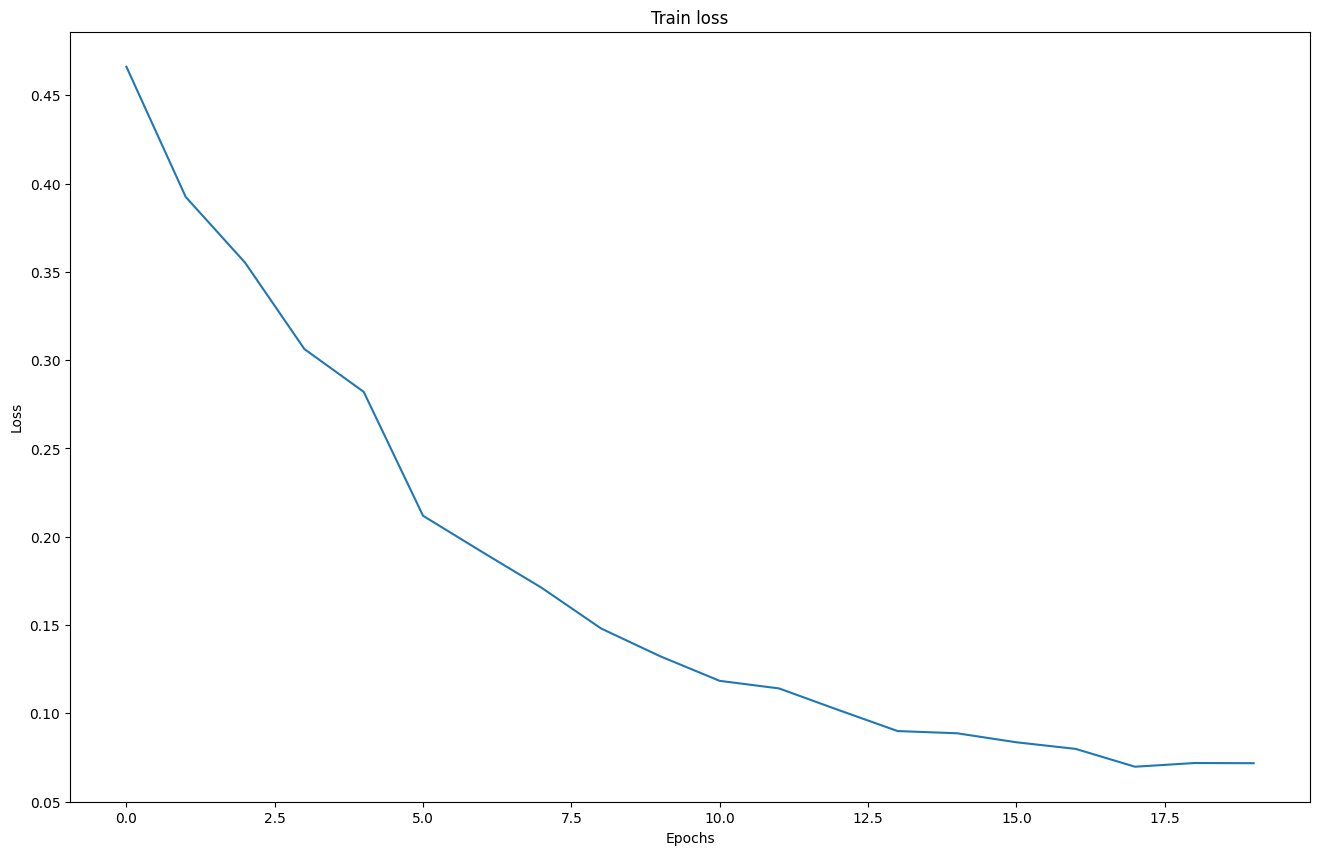

In [ ]:
# đồ thị loss
plt.figure(figsize=(16, 10))
plt.plot(range(len(losses)), losses)
plt.title('Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## **Testing PhoBERT**

In [ ]:
test_x = test_df['text']
test_y = test_df['label']

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# # encode label
# le = LabelEncoder()
# encoded_test_y = le.fit_transform(test_y)
# print(le.classes_)

['CSR' 'No CSR']


In [ ]:
# chia tập train thành 2 phần train và validate với tỉ lệ 9:1
# from sklearn.model_selection import train_test_split

# train_sents, val_sents, train_labels, val_labels = train_test_split(test_x, encoded_train_y, test_size=0.1, random_state = 42)

In [ ]:
# Thực hiện chuyển dataset ban đầu thành subword index
MAX_LEN = 256

test_ids = []
print('Processing text set ...')
for sent in tqdm(test_x):
  subwords = ' ' + bpe.encode(sent) + ' '
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long()
  test_ids.append(encoded_sent)

Processing text set ...


  0%|          | 0/2181 [00:00<?, ?it/s]

In [ ]:
# thêm padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype='long', value=1, truncating='post', padding='post')

In [ ]:
# sau padding
test_ids[1]

array([ 1387,  2774,  1040,    17,  1336,   617,   112,   167,   476,
         223,     8,    16,   513,  8200,   329,  1387,  2774,  2962,
          29,    89, 14460,   199,    40,   466,  1324,   712,   267,
           2,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,

In [ ]:
# Tạo mask để BERT không chú ý tới padding (pad id = 1)
test_masks = []
for sent in test_ids:
  mask = [int(token_id != 1) for token_id in sent]
  test_masks.append(mask)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

BATCH_SIZE = 4

# convert sang tensor
test_inputs = torch.tensor(test_ids)
test_labels = torch.tensor(test_y)
test_masks = torch.tensor(test_masks)

# tạo data loader để train
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=BATCH_SIZE)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Set the model to evaluation mode
BERT_SA.eval()

# Initialize empty lists to store predicted labels and true labels
predicted_labels = []
true_labels = []

# Predict the labels for the test data
for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = BERT_SA(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask
        )
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Convert logits to class labels
        batch_predicted_labels = np.argmax(logits, axis=1)
        predicted_labels.extend(batch_predicted_labels)
        true_labels.extend(label_ids)

# Attach the predicted labels to the test_df dataframe
test_df['predicted_label'] = predicted_labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))

# Print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_mat)


  0%|          | 0/546 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1704
           1       0.65      0.70      0.67       477

    accuracy                           0.85      2181
   macro avg       0.78      0.80      0.79      2181
weighted avg       0.86      0.85      0.85      2181

Confusion Matrix:
[[1524  180]
 [ 145  332]]
